# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [172]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [173]:
# loading the data:
customers = pd.read_csv('../Wholesale customers data.csv')

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [174]:
# Your code here:
customers.columns
customers.head(5)
customers.dtypes
customers.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [175]:
customers.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [176]:
all_col= list(customers[customers.columns.difference(['Channel','Region'])])

for col in all_col:
    outliers_upper = customers[customers[col] > customers[col].mean() + 3 * customers[col].std()]
    outliers_low = customers[customers[col] < customers[col].mean() - 3 * customers[col].std()]


In [177]:
#outliers_upper.head(5)

outliers_upper.head(5)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
23,2,3,26373,36423,22019,5154,4337,16523
47,2,3,44466,54259,55571,7782,24171,6465
56,2,3,4098,29892,26866,2616,17740,1340
61,2,3,35942,38369,59598,3254,26701,2017
85,2,3,16117,46197,92780,1026,40827,2944


In [178]:
outliers_low.head(5)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen


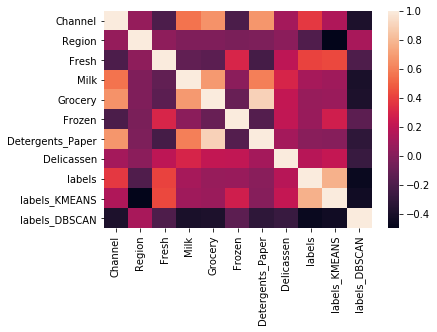

In [179]:
# Your observations here
clean.corr()

import seaborn as sns
sns.heatmap(clean.corr())

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [180]:
for col in all_col:
    clean = customers[customers[col] < customers[col].mean() + 3 * customers[col].std()]
len(clean)

431

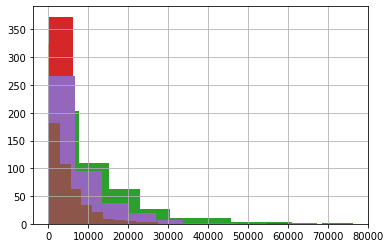

In [181]:
# Your code here

for col in all_col:
    clean[col].hist()


In [182]:
# Your comment here
'''
the distribution is skewed
'''

'\nthe distribution is skewed\n'

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [183]:
# Your import here:
'''
If an algorithm is not using feature scaling method then it can consider the value 
4000 meters to be greater than 6 km

in scaling, you’re changing the range of your data 
while in normalization you’re changing the shape of the distribution of your data

Standard scaler is one of the most used features scaling method and it assumes your data is 
normally distributed within each feature and will scale them such that the distribution is now centered around 0, 
with a standard deviation of 1.
'''

from sklearn.preprocessing import StandardScaler
#from sklearn import preprocessing #it's above

# Your code here:

scaler = StandardScaler()
customers_scale = scaler.fit_transform(clean)
customers_scale = pd.DataFrame(customers_scale, columns=clean.columns)



In [184]:
len(customers_scale)

431

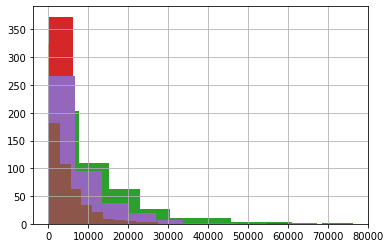

In [185]:
#before scaling
for col in all_col:
    clean[col].hist()

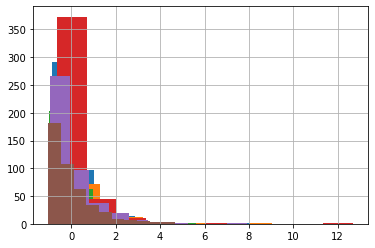

In [186]:
#after scaling
for col in all_col:
    customers_scale[col].hist()

In [187]:
'''
Should I scale Region and Channel? Why do that?
How not to do that?
'''

'\nShould I scale Region and Channel? Why do that?\nHow not to do that?\n'

# Challenge 4 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [188]:
'''
Since K-Means works based on the distance of data points to a cluster center, 
scaling of data to the same scale is critical to the accuracy of the results.
'''
# Your code here:
from sklearn.cluster import KMeans

#scaled data was named customers_scale

#n_clusters = 3
#cluster = KMeans(n_clusters=n_clusters, random_state=0, n_jobs=-1)
cluster = KMeans(n_clusters=5) #everything default

# Train model
model = cluster.fit(customers_scale)
model.labels_ #documentation


array([4, 4, 4, 0, 1, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 0, 4, 0, 4, 0, 4, 0,
       1, 4, 4, 0, 0, 2, 0, 0, 0, 0, 1, 0, 4, 1, 4, 4, 1, 1, 0, 4, 2, 4,
       2, 2, 4, 2, 0, 0, 4, 4, 0, 0, 4, 0, 0, 4, 4, 4, 0, 2, 0, 4, 0, 0,
       0, 1, 0, 4, 4, 0, 0, 2, 0, 0, 0, 4, 4, 0, 4, 1, 0, 1, 0, 0, 2, 1,
       4, 0, 4, 0, 0, 0, 4, 4, 4, 1, 0, 0, 4, 4, 4, 4, 0, 4, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 4, 1, 1, 0, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 4, 4,
       4, 0, 0, 2, 4, 4, 4, 0, 0, 0, 4, 2, 0, 4, 0, 4, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 4, 4, 0, 0, 0, 4, 0, 0, 1, 4, 3, 3, 2, 2, 1, 3, 3, 2,
       3, 3, 3, 2, 3, 3, 3, 4, 3, 2, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3,
       2, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 4, 1, 4, 3, 4, 3, 3, 3, 3,
       1, 0, 0, 1, 0, 0, 4, 0, 4, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4, 3,
       4, 3, 4, 4, 3, 4, 2, 4, 4, 2, 4, 2, 3, 3, 2,

In [189]:
#clean.head(5)
print(len(customers_scale))
print(len(model.labels_))
print(len(clean))

431
431
431


In [190]:
clean['labels_KMEANS'] = model.labels_
clean

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels_KMEANS
0,2,3,12669,9656,7561,214,2674,1338,4
1,2,3,7057,9810,9568,1762,3293,1776,4
2,2,3,6353,8808,7684,2405,3516,7844,4
3,1,3,13265,1196,4221,6404,507,1788,0
4,2,3,22615,5410,7198,3915,1777,5185,1
...,...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204,1
436,1,3,39228,1431,764,4510,93,2346,1
437,2,3,14531,15488,30243,437,14841,1867,2
438,1,3,10290,1981,2232,1038,168,2125,0


Count the values in `labels`.

In [191]:
# Your code here:

#8 clusters was too much (apparently). I will try with 5.
clean['labels_KMEANS'].value_counts().sort_index()

0    176
1     42
2     30
3     84
4     99
Name: labels_KMEANS, dtype: int64

# Challenge 5 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [192]:
# Your code here
from sklearn.cluster import DBSCAN

#scaled data was named customers_scale

cluster = DBSCAN(eps=0.5) #is the default
# The maximum distance between two samples for one to be considered as in the neighborhood of the other.

# Train model
model = cluster.fit(customers_scale)
model.labels_ #documentation

array([-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1,  0, -1,
       -1, -1, -1, -1,  0, -1, -1, -1,  0,  0, -1, -1, -1,  0,  0, -1,  0,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  0, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1,
       -1, -1, -1, -1, -1, -1,  0,  0,  0, -1, -1,  0, -1, -1, -1, -1,  0,
       -1, -1, -1, -1,  0, -1,  0,  0,  0, -1, -1, -1, -1,  0,  0, -1, -1,
       -1, -1,  0, -1, -1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1, -1,
       -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0, -1, -1, -1,  0, -1, -1,
       -1,  0, -1, -1,  0,  0,  0, -1,  0,  0,  0, -1,  0, -1, -1,  0, -1,
       -1, -1, -1,  0, -1, -1, -1, -1,  0,  0,  0, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  0, -1,  0, -1, -1, -1, -1,  0,  0, -1,  0,
       -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,  1, -1, -1,  1, -1, -1,
       -1, -1, -1, -1, -1

In [193]:
clean['labels_DBSCAN'] = model.labels_
clean

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels_KMEANS,labels_DBSCAN
0,2,3,12669,9656,7561,214,2674,1338,4,-1
1,2,3,7057,9810,9568,1762,3293,1776,4,-1
2,2,3,6353,8808,7684,2405,3516,7844,4,-1
3,1,3,13265,1196,4221,6404,507,1788,0,-1
4,2,3,22615,5410,7198,3915,1777,5185,1,-1
...,...,...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204,1,-1
436,1,3,39228,1431,764,4510,93,2346,1,-1
437,2,3,14531,15488,30243,437,14841,1867,2,-1
438,1,3,10290,1981,2232,1038,168,2125,0,-1


Count the values in `labels_DBSCAN`.

In [194]:
# Your code here
clean['labels_DBSCAN'].value_counts().sort_index()

-1    318
 0    104
 1      9
Name: labels_DBSCAN, dtype: int64

# Challenge 6 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

In [195]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


"\n\nI can't plot them side by side and I can't see the clusters properly"

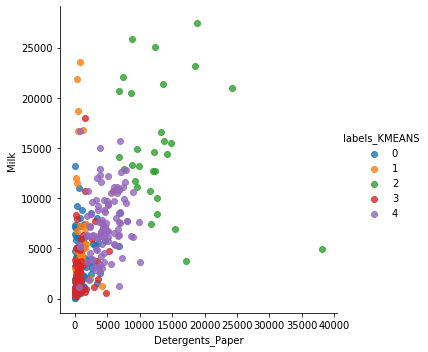

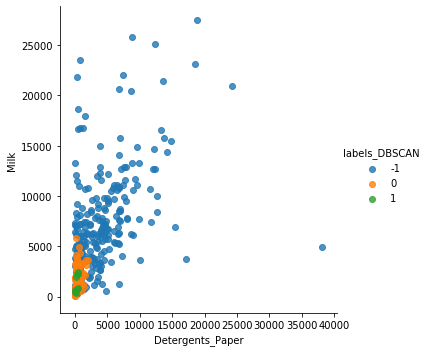

In [196]:
#source: https://nikkimarinsek.com/blog/7-ways-to-label-a-cluster-plot-python

#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
#sns.regplot(x=idx, y=df['x'], ax=ax1)
#sns.regplot(x=idx, y=df['y'], ax=ax2)


sns.lmplot(data=clean, x='Detergents_Paper', y='Milk', hue='labels_KMEANS', 
                   fit_reg=False, legend=True, legend_out=True )

sns.lmplot(data=clean, x='Detergents_Paper', y='Milk', hue='labels_DBSCAN', 
                   fit_reg=False, legend=True, legend_out=True)

fig.show()

'''

I can't plot them side by side and I can't see the clusters properly'''

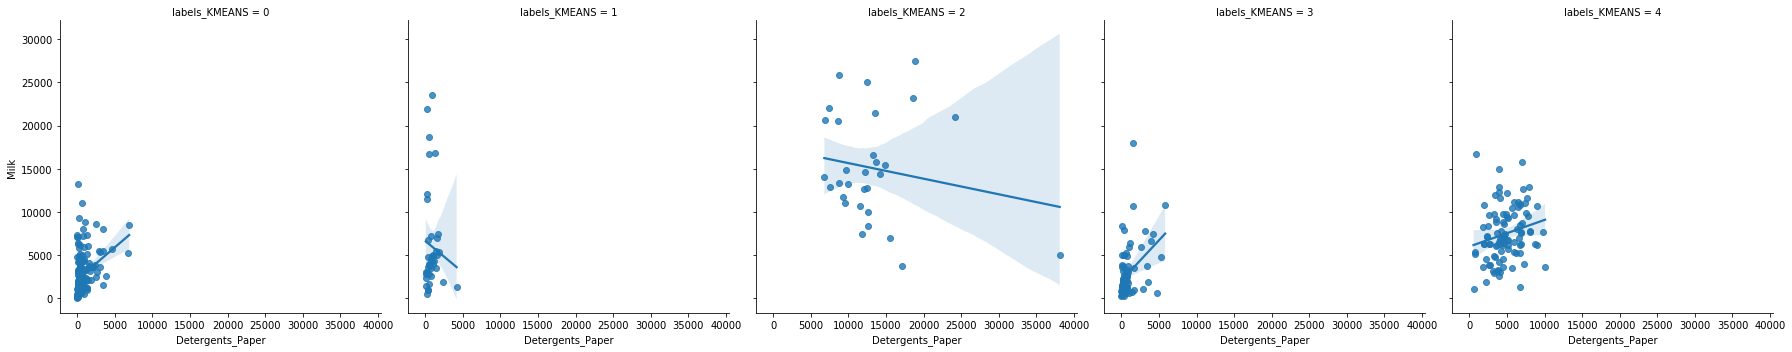

In [197]:
#Here is easier to understand, but I don't like the clusters I see.
sns.lmplot(x='Detergents_Paper', y='Milk', col="labels_KMEANS", data=clean)

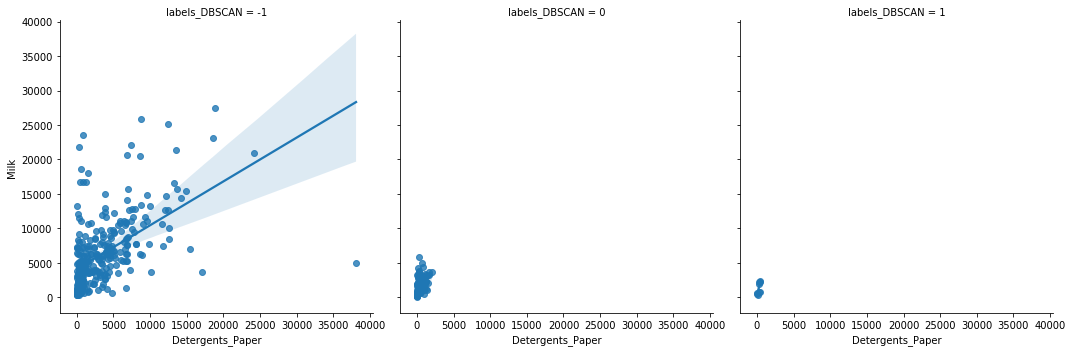

In [198]:
#With DBscan does not get better.
sns.lmplot(x='Detergents_Paper', y='Milk', col="labels_DBSCAN", data=clean)

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


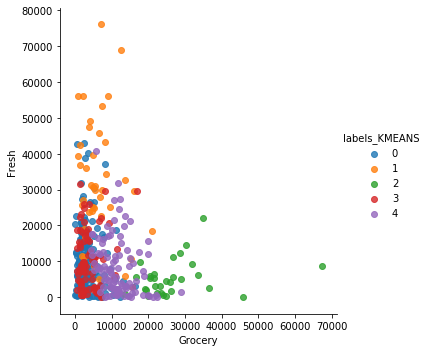

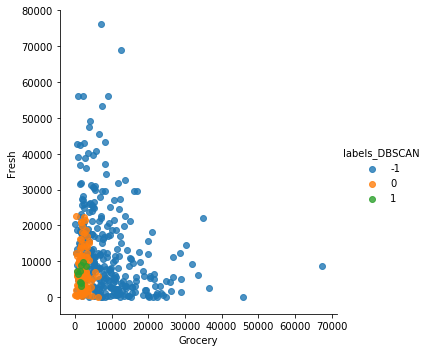

In [199]:
# Your code here:
sns.lmplot(data=clean, x='Grocery', y='Fresh', hue='labels_KMEANS', 
                   fit_reg=False, legend=True, legend_out=True )

sns.lmplot(data=clean, x='Grocery', y='Fresh', hue='labels_DBSCAN', 
                   fit_reg=False, legend=True, legend_out=True)

fig.show()

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

'I wish I removed this outliers'

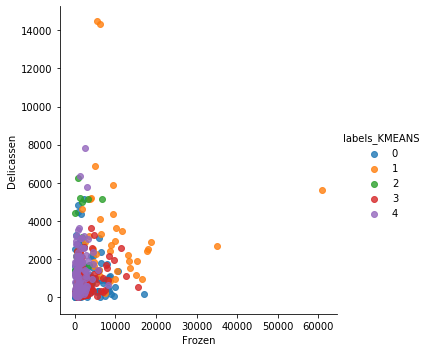

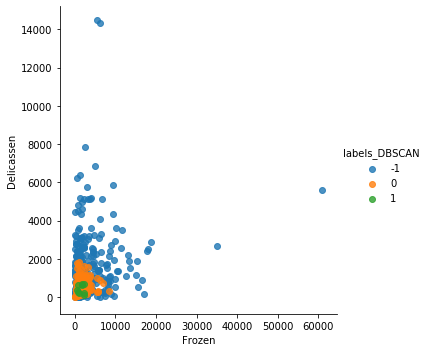

In [200]:
# Your code here:
sns.lmplot(data=clean, x='Frozen', y='Delicassen', hue='labels_KMEANS', 
                   fit_reg=False, legend=True, legend_out=True )

sns.lmplot(data=clean, x='Frozen', y='Delicassen', hue='labels_DBSCAN', 
                   fit_reg=False, legend=True, legend_out=True)

'''I wish I removed this outliers'''

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [220]:
# Your code here:
new_clean_KM = clean.groupby(['labels_KMEANS']).agg(['mean']).reset_index()
new_clean_KM[['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']] #first and last column was a mess, so I removed it

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
,mean,mean,mean,mean,mean,mean
0,10039.147727,2728.204545,3284.590909,2348.676136,733.948864,919.363636
1,31657.095238,6048.642857,6172.047619,10193.666667,829.880952,3248.476190
2,5334.666667,15093.633333,26620.300000,1531.733333,13094.033333,1931.133333
3,10397.607143,2868.321429,3950.547619,3030.166667,875.595238,969.047619
4,8476.424242,7493.545455,11755.888889,1321.505051,4838.515152,1452.626263


In [221]:
new_clean_DB = clean.groupby(['labels_DBSCAN']).agg(['mean']).reset_index()
new_clean_DB[['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']] #last column was a mess, so I removed it

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
,mean,mean,mean,mean,mean,mean
0,12880.248428,6213.610063,9081.808176,3346.267296,3341.817610,1606.477987
1,7822.942308,1748.865385,2200.625000,1874.980769,427.461538,640.932692
2,6620.888889,1334.000000,1635.777778,1522.777778,251.111111,430.111111


Which algorithm appears to perform better?

In [223]:
# Your observations here
'''apparently silhoutte does not work for DBscan, so it's hard to compare.
The Kmeans means are kind of overlaping from group to group, so they don't look good to me'''



"apparently silhoutte does not work for DBscan, so it's hard to compare.\nThe Kmeans means are kind of overlaping from group to group, so they don't look good to me"

# Bonus Challenge 1 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [ ]:
# Your code here

In [ ]:
# Your comment here

# Bonus Challenge 2 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [ ]:
# Your code here

In [ ]:
# Your comment here